In [1]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, GRU, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer as Tokenizer_tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import multilabel_confusion_matrix
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from nltk.tokenize import RegexpTokenizer
from gensim.models import KeyedVectors
from sklearn.utils import shuffle
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import nltk
import re

In [2]:
columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']
df = pd.read_csv('Train.csv', names = columns)
df.head()

,Tweet ID,Entity,Sentiment,Tweet Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
df.drop(['Tweet ID', 'Entity'], axis = 1, inplace = True)
df.tail()

,Sentiment,Tweet Content
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...
74681,Positive,Just like the windows partition of my Mac is l...


In [4]:
def show_details(dataset):
    missed_values = dataset.isnull().sum()
    duplicated_values = dataset.duplicated().sum()
    info_frame = pd.DataFrame({'Missed_Values' : missed_values ,
                              'Duplicated values' :duplicated_values
                               })
    return info_frame.T

show_details(df)

,Sentiment,Tweet Content
Missed_Values,0,686
Duplicated values,4909,4909


In [5]:
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)
show_details(df)

,Sentiment,Tweet Content
Missed_Values,0,0
Duplicated values,0,0


In [6]:
def text_cleaner(txt) :
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # EMOTICONS
                           u"\U0001F300-\U0001F5FF"  # SYMBOLS
                           u"\U0001F680-\U0001F6FF"  # TRANSPORT
                           u"\U0001F1E0-\U0001F1FF"  # FLAGS
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'', txt)
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "I am", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)

    return text

In [7]:
df['Tweet Content'] = df['Tweet Content'].apply(lambda x : text_cleaner(x))
df

,Sentiment,Tweet Content
0,Positive,i am getting on borderlands and i will murder ...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,i am getting on borderlands and i will kill yo...
3,Positive,i am coming on borderlands and i will murder y...
4,Positive,i am getting on borderlands 2 and i will murde...
...,...,...
74677,Positive,just realized that the windows partition of my...
74678,Positive,just realized that my mac window partition is ...
74679,Positive,just realized the windows partition of my mac ...
74680,Positive,just realized between the windows partition of...


In [8]:
df['Sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [9]:
df['Sentiment'].replace({'Positive' : 1 ,  'Negative' : 0 ,'Neutral': 2 , 'Irrelevant' : 2}, inplace = True)
df.head()

,Sentiment,Tweet Content
0,1,i am getting on borderlands and i will murder ...
1,1,i am coming to the borders and i will kill you...
2,1,i am getting on borderlands and i will kill yo...
3,1,i am coming on borderlands and i will murder y...
4,1,i am getting on borderlands 2 and i will murde...


In [10]:
Tokenizer = RegexpTokenizer(r'\w+')

df['Tweet Content'] = df['Tweet Content'].apply(lambda x : Tokenizer.tokenize(x))
df.tail()

,Sentiment,Tweet Content
74677,1,"[just, realized, that, the, windows, partition..."
74678,1,"[just, realized, that, my, mac, window, partit..."
74679,1,"[just, realized, the, windows, partition, of, ..."
74680,1,"[just, realized, between, the, windows, partit..."
74681,1,"[just, like, the, windows, partition, of, my, ..."


In [11]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

# nltk.download('wordnet')
# stopwords_list = wordnet.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
# lemmatizer = WordNetLemmatizer()
Stemmer = PorterStemmer()

def stopwords_cleaner(text):
    # word = [lemmatizer.lemmatize(letter) for letter in text if letter not in stopwords_list]
    word = [Stemmer.stem(letter) for letter in text if letter not in stopwords_list]
    sentence = ' '.join(word)

    return sentence

df['Tweet Content'] = df['Tweet Content'].apply(lambda x : stopwords_cleaner(x))
df.head()

,Sentiment,Tweet Content
0,1,get borderland murder
1,1,come border kill
2,1,get borderland kill
3,1,come borderland murder
4,1,get borderland 2 murder


In [13]:
df_c0 = df[df['Sentiment'] == 0].copy()
df_c1 = df[df['Sentiment'] == 1].copy()
df_c2 = df[df['Sentiment'] == 2].copy()

In [14]:
df_c0 = shuffle(df_c0, random_state = 42)
df_c0 = df_c0.iloc[:len(df_c1)]

In [15]:
df_c2 = shuffle(df_c2, random_state = 42)
df_c2 = df_c2.iloc[:len(df_c1)]

In [16]:
FINAL_DF = pd.DataFrame()
FINAL_DF = pd.concat([FINAL_DF, df_c0], ignore_index = True)
FINAL_DF = pd.concat([FINAL_DF, df_c1], ignore_index = True)
FINAL_DF = pd.concat([FINAL_DF, df_c2], ignore_index = True)
df = FINAL_DF.copy()

In [17]:
MAX_LEN = 100
BATCH = 128
HIDDEN = 128
OUTPUT = 3

In [18]:
# x_train, x_val, y_train, y_val = train_test_split(df['Tweet Content'], df['Sentiment'], test_size = 0.2, random_state = 42)
x_train = df['Tweet Content'].copy()
y_train = df['Sentiment'].copy()

In [19]:
Tokenizer = Tokenizer_tf()
Tokenizer.fit_on_texts(df['Tweet Content'].values.tolist())

x_train = Tokenizer.texts_to_sequences(x_train)
# x_val = Tokenizer.texts_to_sequences(x_val)

In [20]:
x_train = pad_sequences(x_train, maxlen = MAX_LEN)
# x_val = pad_sequences(x_val, maxlen = MAX_LEN)

In [21]:
embedding_path = 'glove.6B.300d.txt'
embedding_dim = 300

embedding_matrix = {}
with open(embedding_path, 'r', encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embedding_matrix[word] = vector

In [22]:
vocab_size = len(embedding_matrix)
embedding_layer = tf.keras.layers.Embedding(
    input_dim = vocab_size,
    output_dim = embedding_dim,
    weights = [np.array(list(embedding_matrix.values()))],
    input_length = MAX_LEN,
    trainable = False)

In [23]:
ALFA = 0.001
BETA = 0.0001

adam_optimizer = Adam(learning_rate = ALFA)

model = Sequential()

model.add(embedding_layer)
model.add(GRU(HIDDEN, activation = 'tanh', use_bias = True, kernel_regularizer = l2(BETA)))
model.add(Dense(OUTPUT, activation = 'softmax'))

model.compile(optimizer = adam_optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          120000000 
                                                                 
 gru (GRU)                   (None, 128)               165120    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 120165507 (458.40 MB)
Trainable params: 165507 (646.51 KB)
Non-trainable params: 120000000 (457.76 MB)
_________________________________________________________________


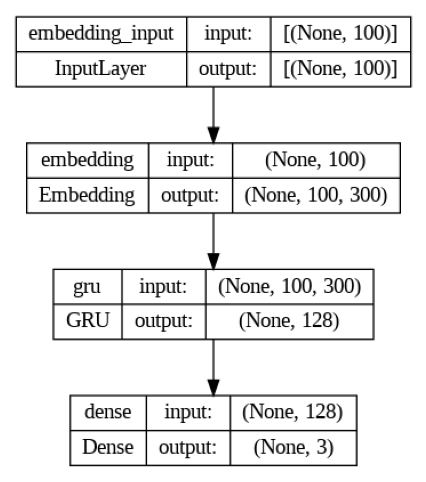

In [24]:
plot_model(model, to_file = 'model.png', show_shapes = True)

img = plt.imread('model.png')
plt.figure(figsize = (8, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
early_stopping = EarlyStopping(monitor = 'accuracy', patience = 2, restore_best_weights = True)

history = model.fit(x_train, y_train, epochs = 20, batch_size = BATCH, callbacks = [early_stopping])

Epoch 1/20
449/449 [==============================] - 173s 377ms/step - loss: 0.9778 - accuracy: 0.5387
Epoch 2/20
449/449 [==============================] - 165s 367ms/step - loss: 0.7931 - accuracy: 0.6685
Epoch 3/20
449/449 [==============================] - 163s 363ms/step - loss: 0.6592 - accuracy: 0.7454
Epoch 4/20
449/449 [==============================] - 175s 391ms/step - loss: 0.5244 - accuracy: 0.8161
Epoch 5/20
449/449 [==============================] - 166s 370ms/step - loss: 0.4111 - accuracy: 0.8688
Epoch 6/20
449/449 [==============================] - 164s 365ms/step - loss: 0.3373 - accuracy: 0.9028
Epoch 7/20
449/449 [==============================] - 165s 366ms/step - loss: 0.2825 - accuracy: 0.9255
Epoch 8/20
449/449 [==============================] - 169s 376ms/step - loss: 0.2441 - accuracy: 0.9425
Epoch 9/20
449/449 [==============================] - 164s 365ms/step - loss: 0.2222 - accuracy: 0.9497
Epoch 10/20
449/449 [==============================] - 166s 370m

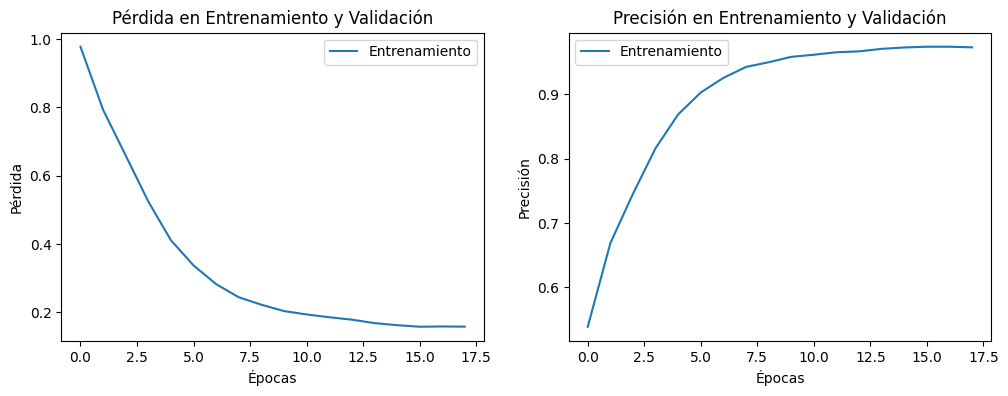

In [ ]:
train_loss = history.history['loss']
# val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Entrenamiento')
# plt.plot(val_loss, label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Entrenamiento')
# plt.plot(val_acc, label='Validación')
plt.title('Precisión en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [ ]:
y_preds = model.predict(x_train)

1795/1795 [==============================] - 127s 71ms/step


In [ ]:
THRESHOLD = 0.5

for i in range(len(y_preds)) :
    for j in range(0, 3) :
        if y_preds[i][j] >= THRESHOLD :
            y_preds[i][j] = 1
        else :
            y_preds[i][j] = 0

In [ ]:
y_pred = pd.DataFrame(y_preds, columns = ['Sentiment_0', 'Sentiment_1', 'Sentiment_2'])
y_pred.head()

,Sentiment_0,Sentiment_1,Sentiment_2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [ ]:
y_train = pd.get_dummies(y_train, columns = ['Sentiment'])
y_train.rename(columns = {0: 'Sentiment_0', 1: 'Sentiment_1', 2: 'Sentiment_2'}, inplace = True)

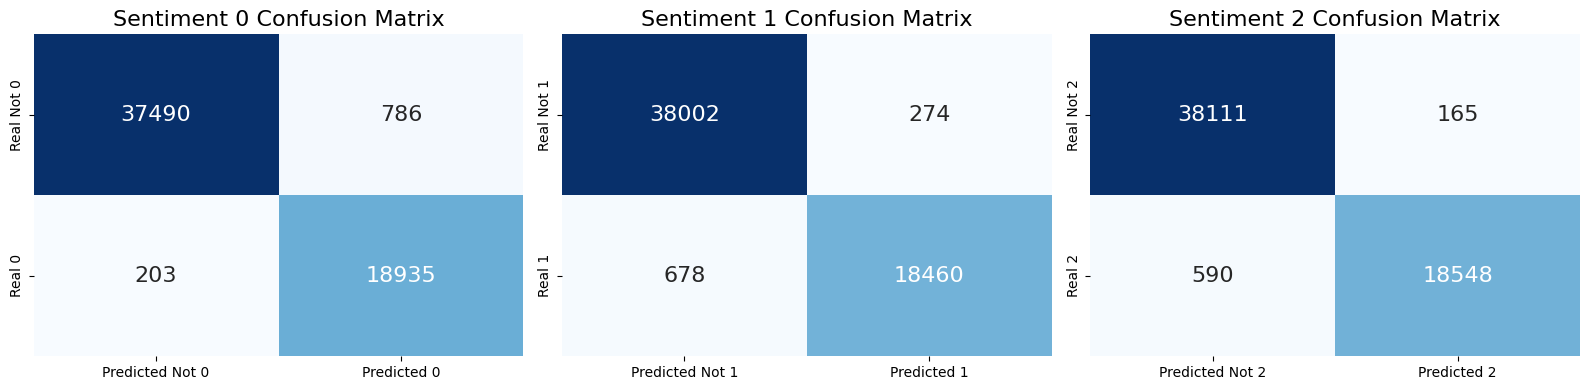

In [ ]:
conf_matrix = multilabel_confusion_matrix(y_train, y_pred)

num_classes = len(conf_matrix)
fig, axes = plt.subplots(1, num_classes, figsize = (16, 4))

for i in range(num_classes):
    y_labels = [f'Real Not {i}', f'Real {i}']
    x_labels = [f'Predicted Not {i}', f'Predicted {i}']
    sns.heatmap(conf_matrix[i], annot = True, fmt = 'd', cmap = 'Blues', cbar = False,
                xticklabels = x_labels, yticklabels = y_labels, ax = axes[i], annot_kws = {"size": 16})
    axes[i].set_title(f'Sentiment {i} Confusion Matrix', fontsize = 16)

plt.tight_layout()
plt.show()

In [ ]:
w_precision = precision_score(y_train, y_preds, average = 'weighted')
print('Weighted Precision: ', w_precision)
w_recall = recall_score(y_train, y_preds, average = 'weighted')
print('Weighted Recall: ', w_recall)
w_f1 = f1_score(y_train, y_preds, average = 'weighted')
print('Weighted F1 Score: ', w_f1)
print()
m_precision = precision_score(y_train, y_preds, average = 'macro')
print('Macro Precision: ', m_precision)
m_recall = recall_score(y_train, y_preds, average = 'macro')
print('Macro Recall: ', m_recall)
m_f1 = f1_score(y_train, y_preds, average = 'macro')
print('Macro F1 Score: ', m_f1)
print()
accuracy = accuracy_score(y_train, y_preds)
print('Accuracy: ', accuracy)

Weighted Precision:  0.9789002650759488
Weighted Recall:  0.9743790713066499
Weighted F1 Score:  0.9764883576901295

Macro Precision:  0.9789002650759487
Macro Recall:  0.9743790713066499
Macro F1 Score:  0.9764883576901294

Accuracy:  0.9743790713066499


In [ ]:
# model.save('model_v2.keras')

In [ ]:
# model = tf.keras.models.load_model('model_v2.keras')

In [ ]:
Test_df = pd.read_csv('Test.csv', names = columns)
Test_df.head()

,Tweet ID,Entity,Sentiment,Tweet Content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [ ]:
Test_df.drop(['Tweet ID', 'Entity'], axis = 1, inplace = True)
Test_df['Sentiment'].replace({'Positive' : 1 ,  'Negative' : 0 ,
                              'Neutral': 2 , 'Irrelevant' : 2}, inplace = True)
Test_df = pd.get_dummies(Test_df, columns = ['Sentiment'])
Test_df.tail()

,Tweet Content,Sentiment_0,Sentiment_1,Sentiment_2
995,⭐️ Toronto is the arts and culture capital of ...,0,0,1
996,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,0,0,1
997,Today sucked so it’s time to drink wine n play...,0,1,0
998,Bought a fraction of Microsoft today. Small wins.,0,1,0
999,Johnson & Johnson to stop selling talc baby po...,0,0,1


In [ ]:
Test_df.drop_duplicates(inplace = True)
Test_df.dropna(inplace = True)
Test_df['Tweet Content'] = Test_df['Tweet Content'].apply(lambda x : text_cleaner(x))
Tokenizer = RegexpTokenizer(r'\w+')
Test_df['Tweet Content'] = Test_df['Tweet Content'].apply(lambda x : Tokenizer.tokenize(x))
Test_df['Tweet Content'] = Test_df['Tweet Content'].apply(lambda x : stopwords_cleaner(x))
Test_df

,Tweet Content,Sentiment_0,Sentiment_1,Sentiment_2
0,mention facebook struggl motiv go run day tran...,0,0,1
1,bbc news amazon boss jeff bezo reject clai am ...,0,0,1
2,microsoft pay word function poorli samsungu ch...,1,0,0
3,csgo matchmak full closet hack truli aw game,1,0,0
4,presid slap american face realli commit unlaw ...,0,0,1
...,...,...,...,...
995,toronto art cultur capit canada wonder want st...,0,0,1
996,actual good move tot bring viewer one peopl go...,0,0,1
997,today suck ti ame drink wine n play borderland...,0,1,0
998,bought fraction microsoft today small win,0,1,0


In [ ]:
Tokenizer = Tokenizer_tf()
Tokenizer.fit_on_texts(Test_df['Tweet Content'].values.tolist())
x_test = Test_df['Tweet Content']
x_test = Tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen = MAX_LEN)
x_test

array([[   0,    0,    0, ...,  764,  597,  260],
       [   0,    0,    0, ...,  135, 1637, 1638],
       [   0,    0,    0, ..., 1640, 1641, 1642],
       ...,
       [   0,    0,    0, ...,  216,   34,  836],
       [   0,    0,    0, ...,   92,  913,   93],
       [   0,    0,    0, ..., 4445, 4446, 4447]], dtype=int32)

In [ ]:
y_test = pd.DataFrame(Test_df[['Sentiment_0', 'Sentiment_1', 'Sentiment_2']].copy())
y_test.head()

,Sentiment_0,Sentiment_1,Sentiment_2
0,0,0,1
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1


In [ ]:
y_preds = model.predict(x_test)

32/32 [==============================] - 3s 87ms/step


In [ ]:
THRESHOLD = 0.5

for i in range(len(y_preds)) :
    for j in range(0, 3) :
        if y_preds[i][j] >= THRESHOLD :
            y_preds[i][j] = 1
        else :
            y_preds[i][j] = 0

In [ ]:
y_pred = pd.DataFrame(y_preds, columns = ['Sentiment_0', 'Sentiment_1', 'Sentiment_2'])
y_pred.head()

,Sentiment_0,Sentiment_1,Sentiment_2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


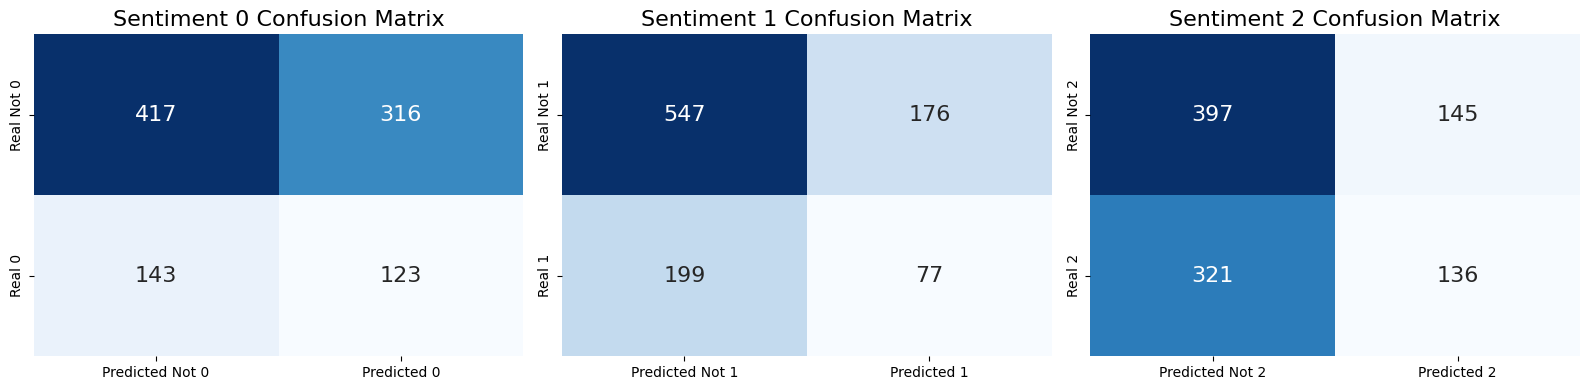

In [ ]:
conf_matrix = multilabel_confusion_matrix(y_test, y_pred)

num_classes = len(conf_matrix)
fig, axes = plt.subplots(1, num_classes, figsize = (16, 4))

for i in range(num_classes):
    y_labels = [f'Real Not {i}', f'Real {i}']
    x_labels = [f'Predicted Not {i}', f'Predicted {i}']
    sns.heatmap(conf_matrix[i], annot = True, fmt='d', cmap = 'Blues', cbar = False,
                xticklabels = x_labels, yticklabels = y_labels, ax = axes[i], annot_kws = {"size": 16})
    axes[i].set_title(f'Sentiment {i} Confusion Matrix', fontsize = 16)

plt.tight_layout()
plt.show()

In [ ]:
w_precision = precision_score(y_test, y_preds, average = 'weighted')
print('Weighted Precision: ', w_precision)
w_recall = recall_score(y_test, y_preds, average = 'weighted')
print('Weighted Recall: ', w_recall)
w_f1 = f1_score(y_test, y_preds, average = 'weighted')
print('Weighted F1 Score: ', w_f1)
print()
m_precision = precision_score(y_test, y_preds, average = 'macro')
print('Macro Precision: ', m_precision)
m_recall = recall_score(y_test, y_preds, average = 'macro')
print('Macro Recall: ', m_recall)
m_f1 = f1_score(y_test, y_preds, average = 'macro')
print('Macro F1 Score: ', m_f1)
print()
accuracy = accuracy_score(y_test, y_preds)
print('Accuracy: ', accuracy)

Weighted Precision:  0.38009005852454647
Weighted Recall:  0.33633633633633636
Weighted F1 Score:  0.34194039209168736

Macro Precision:  0.3561719411859177
Macro Recall:  0.34632817336526234
Macro F1 Score:  0.3362050559196284

Accuracy:  0.33633633633633636


In [ ]:
n = random.randint(0, len(Test_df))
print(n)

12


In [ ]:
print('Real Labels')
print(Test_df.iloc[n])
print()
print('Predicted Labels')
print(y_preds[n])

Real Labels
Tweet Content    fredtjoseph hey fred comcast cut cabl verizon ...
Sentiment_0                                                      1
Sentiment_1                                                      0
Sentiment_2                                                      0
Name: 12, dtype: object

Predicted Labels
[1. 0. 0.]


In [ ]:
text = "I feel pretty, oh so pretty, i feel pretty and witty"

In [ ]:
text = text_cleaner(text)
Tokenizer = RegexpTokenizer(r'\w+')
t_text = Tokenizer.tokenize(text)
text = stopwords_cleaner(t_text)

In [ ]:
Tokenizer = Tokenizer_tf()
Tokenizer.fit_on_texts(text.split())
text = Tokenizer.texts_to_sequences([text])
text = pad_sequences(text, maxlen = MAX_LEN)
text

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 1, 3, 1, 2, 1, 4]], dtype=int32)

In [ ]:
pred = model.predict(text)

1/1 [==============================] - 0s 35ms/step


In [ ]:
THRESHOLD = 0.5

for i in range(len(pred)) :
    for j in range(0, 3) :
        if pred[i][j] >= THRESHOLD :
            pred[i][j] = 1
        else :
            pred[i][j] = 0

In [ ]:
pred

array([[1., 0., 0.]], dtype=float32)